<table width="50%"><tr>
<td> <img src="../../img/dipy_logo.png" align="left" alt="Drawing" style="width: 155px;"/> </td>
<td> <img src="../../img/gsoc_logo.png" align="right" alt="Drawing" style="width: 220px;"/> </td>
</tr></table>

**Student**\
David Romero-Bascones\
**Mentors**\
Bramsh Qamar Chandio\
Shreyas Fadnavis\
Jong Sung Park

# **Bundle combination methods**

## Imports and help functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

from dipy.align.bundlemin import distance_matrix_mdf
from dipy.io.streamline import load_trk
from dipy.segment.clustering import QuickBundles
from dipy.tracking.streamline import set_number_of_points, select_random_set_of_streamlines, orient_by_streamline
from dipy.viz import actor, window

In [2]:
def distance_matrix_mdf_start_end(bundle_1, bundle_2):
    bundle_1 = set_number_of_points(bundle_1, 2)
    bundle_2 = set_number_of_points(bundle_2, 2)
    return distance_matrix_mdf(bundle_1, bundle_2)

In [3]:
def combine_bundles(bundle1, bundle2, comb_method='rlap', distance='mdf',
                    n_stream=2000, z_th=None):
    "Random pick"
    if comb_method == 'random_pick':
        bundles = np.concatenate((bundle1, bundle2))
        return select_random_set_of_streamlines(bundles, n_stream)

    "Preprocessing"
    # Set as bundle 1 the bundle with less streamlines
    if len(bundle2) < len(bundle1):
        aux = bundle1.copy()
        bundle1 = bundle2
        bundle2 = aux

    bundle1 = orient_by_streamline(bundle1, bundle1[0])
    qb = QuickBundles(threshold=50.)
    centroid = qb.cluster(bundle2).centroids[0]

    bundle1 = orient_by_streamline(bundle1, centroid)
    bundle2 = orient_by_streamline(bundle2, centroid)

    # Compute distance matrix
    if distance == 'mdf':
        cost = distance_matrix_mdf(bundle1, bundle2)
    elif distance == 'mdf_se':
        cost = distance_matrix_mdf_start_end(bundle1,bundle2)
    else:
        raise ValueError("Incorrect distance metric")    

    "Step 1: streamline matching (N1 sreamlines)"
    combined = []

    # Closest streamline
    if comb_method == 'closest_keep':
        for i, stream in enumerate(bundle1):         
            # Find the closest streamline and save it
            ind_match = np.argmin(cost[i,:])
            stream_match = bundle2[ind_match]

            # Combine matched streamlines and generate the atlas
            stream_mean = np.mean([stream, stream_match], axis=0)
            combined.append(stream_mean)
        return combined
    elif comb_method == 'closest_remove':
        for i, stream in enumerate(bundle1):         
            # Find the closest streamline and save it
            ind_match = np.argmin(cost[i,:])
            stream_match = bundle2[ind_match]

            # Remove matched streamilne (set distance to max)                      
            cost[:,ind_match] = float('inf')

            # Combine matched streamlines and generate the atlas
            stream_mean = np.mean([stream, stream_match], axis=0)
            combined.append(stream_mean)
        return combined
                                      
    # Minimize the sum of distances (RLAP)
    matched_pairs = np.asarray(linear_sum_assignment(cost)).T

    if z_th is not None:
        d = [cost[a, b] for a, b in matched_pairs]
        mean_d = np.mean(d)
        std_d = np.std(d)

    # Go through matched streamlines
    disc = 0
    for ind1, ind2 in matched_pairs:
        stream1 = bundle1[ind1]
        stream2 = bundle2[ind2]

        # Discard too distant streamline pairs
        if z_th is not None:
            z = (cost[ind1, ind2] - mean_d)/std_d
            if z > z_th:
                disc += 1
                continue

        stream_mean = np.mean([stream1, stream2], axis=0)
        combined.append(stream_mean)
    print(f"Discarded {disc} streamlines as outliers.")
  
    "Step 2: rest of N2-N1 streamlines"
    # If just RLAP we don't care about unmatched streamlines
    if comb_method == 'rlap':
        return combined

    # Not matched streamlines
    ind2_matched = matched_pairs[:, 1]
    ind2_unmatched = np.setdiff1d(np.arange(len(bundle2)), ind2_matched)

    if comb_method == 'rlap_closest':
        for ind2 in ind2_unmatched:
            ind1 = np.argmin(cost[:, ind2])

            stream1 = bundle1[ind1]
            stream2 = bundle2[ind2]

            stream_mean = np.mean([stream1, stream2], axis=0)
            combined.append(stream_mean)
    elif comb_method == 'rlap_keep':
        for ind2 in ind2_unmatched:
            combined.append(bundle2[ind2])
    else:
        raise ValueError("Not supported bundle combination method")
    return combined

In [4]:
def render_bundles(bundles, linewidth=None, colors=None, opacity=None, show_3d=False, show_2d=False):

    n_bundle = len(bundles)
    if opacity is None:
        opacity = np.repeat(0.5, n_bundle)
    if linewidth is None:
        linewidth = np.repeat(0.3, n_bundle)
    scene = window.Scene()
    scene.SetBackground(1., 1, 1)
    for (i, bundle) in enumerate(bundles):
        lines_actor = actor.streamtube(bundle, linewidth=linewidth[i], opacity=opacity[i], colors=colors[i])
        
        lines_actor.RotateX(-90)
        lines_actor.RotateZ(90)
        scene.add(lines_actor)
    if show_3d:
        window.show(scene)
    if show_2d:
        img = window.snapshot(scene, size=(600, 600))
        return img

In [5]:
def show_bundles(bundles, i, j, figsize, colors=None, labels=None):
    
    if colors is None:
        colors = list(np.random.rand(len(bundles), 3))
    fig, ax = plt.subplots(i, j, figsize=figsize)

    for i, bundle in enumerate(bundles):

        if type(bundle) is not list():
            bundle = [bundle]
        if len(colors[i])==3:
            my_colors = [colors[i]]
            
        I = render_bundles(bundle, colors=my_colors, show_2d=True)
        ax[i].imshow(I)
        ax[i].invert_yaxis()
        _ = ax[i].axis('off')
        if labels is not None:
            ax[i].set_title(labels[i],fontsize=16)

## Load two bundles

In [6]:
in_dir = '/home/david/Dropbox (MGEP)/projects/GSoC-2021/data/PPMI_data'
subjects = pd.read_csv(f'{in_dir}/subjects.csv', delimiter='\t', dtype='object')['participant']
n_subject = len(subjects)

bundle_name = 'AF_L'
n_point = 20
n_stream = 3000

# Load two bundles and preprocess them
np.random.seed(666)
ind = np.random.choice(np.arange(n_subject), 2)
sub1 = subjects[ind[0]]
sub2 = subjects[ind[1]]
      
file = f'{in_dir}/{sub1}/rec_bundles/moved_{bundle_name}__recognized.trk'
bundle_obj = load_trk(file, reference='same', bbox_valid_check=False)   
bundle1 = set_number_of_points(bundle_obj.streamlines, n_point)
bundle1 = select_random_set_of_streamlines(bundle1, n_stream)

file = f'{in_dir}/{sub2}/rec_bundles/moved_{bundle_name}__recognized.trk'
bundle_obj = load_trk(file, reference='same', bbox_valid_check=False)   
bundle2 = set_number_of_points(bundle_obj.streamlines, n_point)
bundle2 = select_random_set_of_streamlines(bundle2, n_stream)

print(f"sub1:{sub1} n1:{len(bundle1)}")
print(f"sub2:{sub2} n2:{len(bundle2)}")

# Visualize two bundles
show_bundles([bundle1, bundle2], 1, 2, figsize=(16,10), colors =[[1,0,0],[0,0,1]])

FileNotFoundError: [Errno 2] No such file or directory: '/home/david/Dropbox (MGEP)/projects/GSoC-2021/data/PPMI_data/subjects.csv'

## Random selection of streamlines

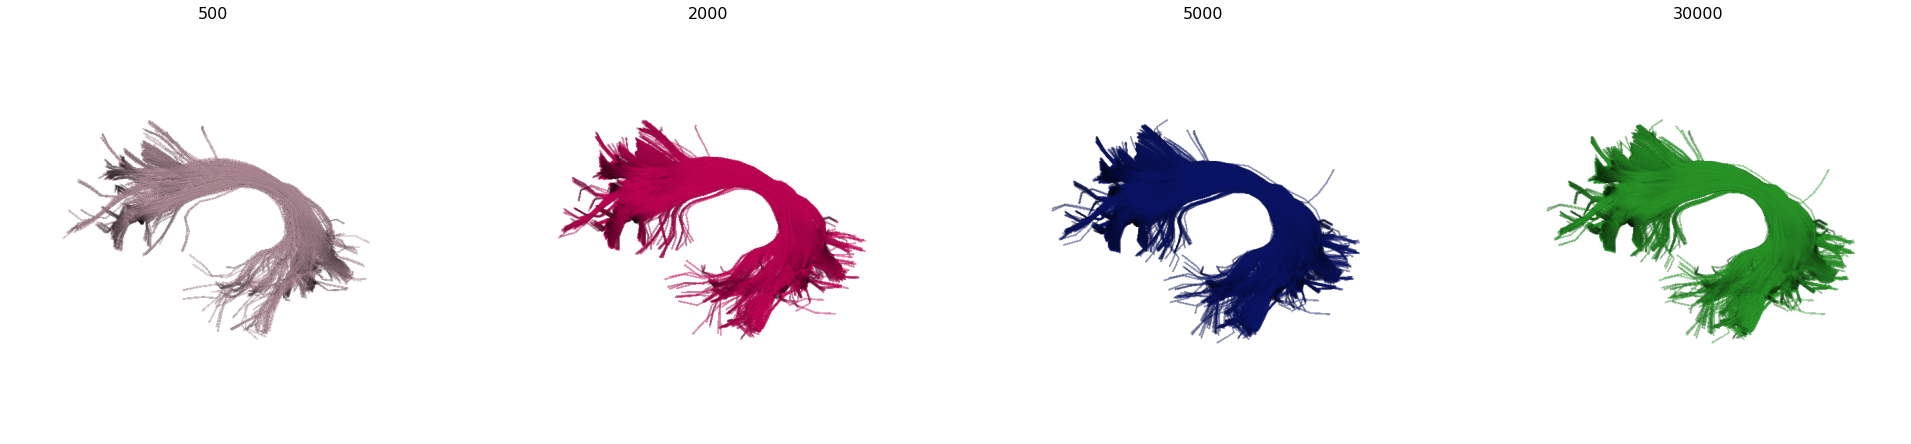

In [125]:
bundles = []
n_stream_pick = [500, 2000, 5000, 30000]
for n in n_stream_pick:
    bundles.append(combine_bundles(bundle1,bundle2,comb_method='random_pick', n_stream=n))
show_bundles(bundles, 1, len(n_stream_pick), (34,8), labels=n_stream_pick)

## Closest streamline

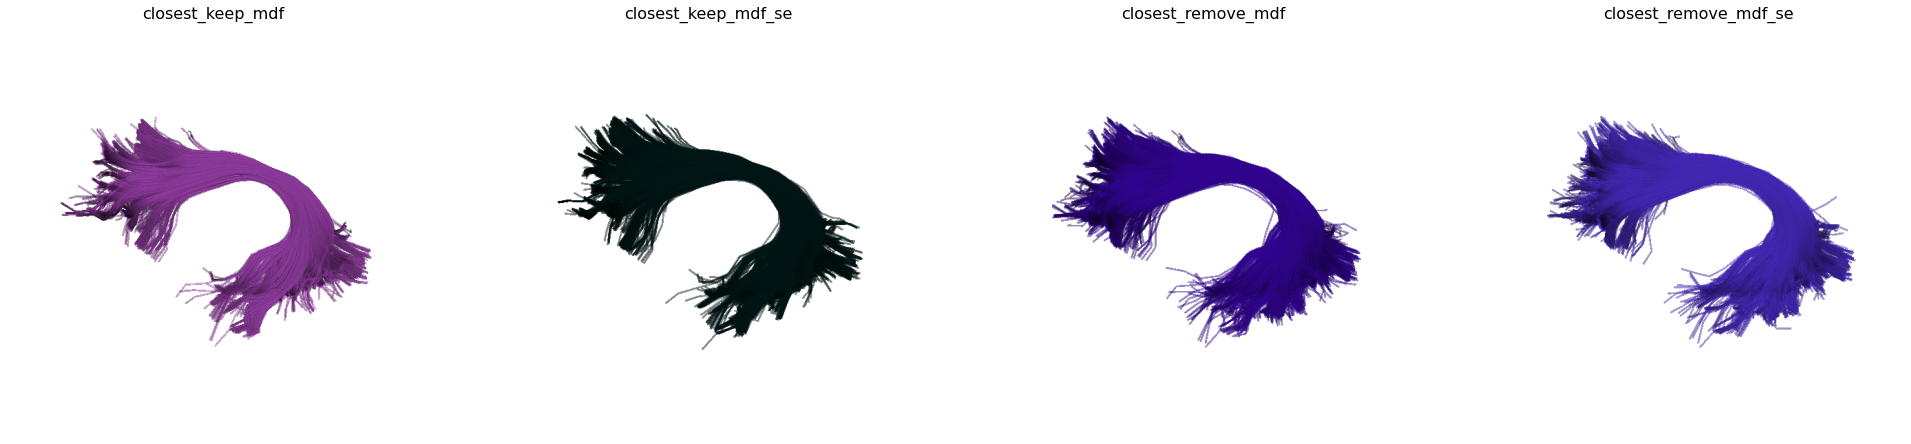

In [126]:
methods = ['closest_keep','closest_remove']
distances = ['mdf','mdf_se']

bundles = []
labels = []
for method in methods:
    for distance in distances:
        bundles.append(combine_bundles(bundle1,bundle2,comb_method=method,distance=distance))
        labels.append(f'{method}_{distance}')

show_bundles(bundles, 1, len(bundles), (34,8), labels=labels)   

## Graph-matching

## Linear Assignment Problem

Discarded 0 streamlines as outliers.
Discarded 0 streamlines as outliers.
Discarded 0 streamlines as outliers.
Discarded 0 streamlines as outliers.


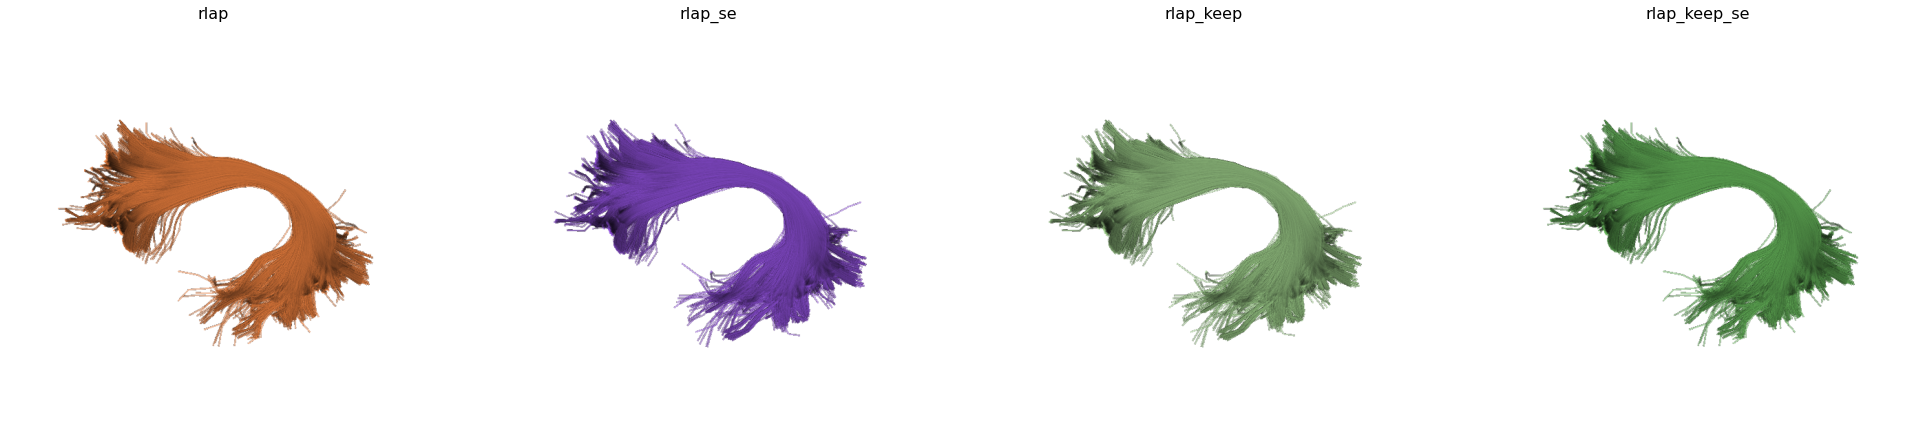

In [127]:
method = ['rlap','rlap_se','rlap_keep','rlap_keep_se']

bundles_rlap = combine_bundles(bundle1,bundle2,comb_method='rlap',distance='mdf')
bundles_rlap_se = combine_bundles(bundle1,bundle2,comb_method='rlap',distance='mdf_se')
bundles_rlap_keep = combine_bundles(bundle1,bundle2,comb_method='rlap_keep',distance='mdf')
bundles_rlap_keep_se = combine_bundles(bundle1,bundle2,comb_method='rlap_keep',distance='mdf_se')
          
bundles = [bundles_rlap,bundles_rlap_se, bundles_rlap_keep_se, bundles_rlap_keep]
show_bundles(bundles, 1, len(bundles), (34,8), labels=method)   

## Discarding distant streamlines